In [198]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import time
import pandas as pd

N_WEIGHTS = 9

In [199]:
print("Carregando dados")
data = np.loadtxt('./data/wine.data', delimiter=',')

X, y = data[:, 1:], data[:,0]

# Transforma em problema de classificação binária
idxs = [i for i in range(len(y)) if y[i] == 1 or y[i] == 2]
X, y = X[idxs], y[idxs]

# Normaliza os dados
X = (X - X.mean(axis=0))/(X.max(axis=0) - X.min(axis=0))
X = np.hstack((X, np.ones(len(X)).reshape(len(X),1)))
# Transforma variável target
y = np.array(list(map(lambda x: 0 if x == 1 else 1, y)))

print(f"Dataset: {X.shape[0]} amostras, {X.shape[1]} features")

Carregando dados
Dataset: 130 amostras, 14 features


In [200]:
print("\nTreinando modelo benchmark (Scikit-Learn)")
reg = LogisticRegression(solver='sag', C=100000, max_iter=10000).fit(X, y)
L_star = log_loss(y, reg.predict_proba(X))
print(f"Loss L* (benchmark) = {L_star:.10f}")


Treinando modelo benchmark (Scikit-Learn)
Loss L* (benchmark) = 0.0003896440


In [201]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cross_entropy_loss(y, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -(1/len(y))*np.sum(y*np.log(y_pred) + (1 - y)*np.log(1 - y_pred))
    return loss

def cross_entropy_grad(y, y_pred, X):
    return list(np.dot((y_pred - y), X)[0])

def compute_loss_for_weights(w, X, y):
    """Calcula loss para um dado conjunto de pesos"""
    y_pred = sigmoid(np.dot(w.T, X.T))
    return cross_entropy_loss(y, y_pred)

def train_coordinate_descent(X_train, y_train, num_weights, eta=0.01, patience=1000, 
                             min_improvement=1e-6, max_iter=1000000, desc=""):
    """Treinar com descida coordenada"""
    w = np.zeros(num_weights).reshape(num_weights, 1)
    loss_history = []
    weights_history = []
    best_loss = float('inf')
    no_improvement_count = 0
    
    start_time = time.time()
    pbar = tqdm(desc=desc, total=max_iter)
    
    for t in range(max_iter):
        y_pred = sigmoid(np.dot(w.T, X_train.T))
        current_loss = cross_entropy_loss(y_train, y_pred)
        loss_history.append(current_loss)
        
        grad = list(np.dot((y_pred - y_train), X_train)[0])
        grad_abs = [abs(g) for g in grad]
        best_index = grad_abs.index(max(grad_abs))
        
        w[best_index] = w[best_index] - eta*grad[best_index]
        weights_history.append(w.flatten().copy())
        
        if current_loss < best_loss - min_improvement:
            best_loss = current_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1
        
        if no_improvement_count >= patience:
            print(f"\nConvergencia atingida na iteracao {t}")
            pbar.close()
            break
        
        pbar.update(1)
        if t == max_iter - 1:
            print(f"\nMaximo de iteracoes ({max_iter}) atingido")
            pbar.close()
    
    training_time = time.time() - start_time
    weights_history = np.array(weights_history)
    
    y_pred = sigmoid(np.dot(w.T, X_train.T))
    y_pred_class = np.array(list(map(lambda x: 1 if x >= 0.5 else 0, y_pred.flatten())))
    accuracy = accuracy_score(y_train, y_pred_class)
    
    return {
        'weights': w,
        'loss_history': loss_history,
        'weights_history': weights_history,
        'time': training_time,
        'iterations': len(loss_history),
        'accuracy': accuracy,
        'final_loss': loss_history[-1]
    }

In [202]:
w_gradient = np.zeros(14).reshape(14, 1)
eta = 0.01
num_features = 14
patience = 1000
min_improvement = 1e-6
max_iter = 1000000

loss_gradient = []
weights_history_gradient = []
gradient_selections = np.zeros(num_features)
iteration_log = []

best_loss = float('inf')
no_improvement_count = 0

start_time = time.time()
pbar = tqdm(desc="Descida com Gradiente (14 pesos)", total=max_iter)

for t in range(max_iter):
    y_pred = sigmoid(np.dot(w_gradient.T, X.T))
    current_loss = cross_entropy_loss(y, y_pred)
    loss_gradient.append(current_loss)
    
    grad = cross_entropy_grad(y, y_pred, X)
    grad_abs = [abs(g) for g in grad]
    best_index = grad_abs.index(max(grad_abs))
    gradient_selections[best_index] += 1
    
    w_gradient[best_index] = w_gradient[best_index] - eta*grad[best_index]
    weights_history_gradient.append(w_gradient.flatten().copy())
    
    if t % 1000 == 0 or t < 10:
        iteration_log.append({
            'Iteracao': t,
            'Loss': current_loss,
            'Melhor Indice': best_index,
            'Gradiente Max': max(grad_abs),
            'Delta Loss': current_loss - best_loss if t > 0 else 0
        })
    
    if current_loss < best_loss - min_improvement:
        best_loss = current_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
    
    if no_improvement_count >= patience:
        print(f"\nConvergencia atingida na iteracao {t}")
        pbar.close()
        break
    
    pbar.update(1)
    if t == max_iter - 1:
        print(f"\nMaximo de iteracoes ({max_iter}) atingido")
        pbar.close()

time_gradient = time.time() - start_time
weights_history_gradient = np.array(weights_history_gradient)
total_iterations_14 = len(loss_gradient)

y_pred_gradient = sigmoid(np.dot(w_gradient.T, X.T))
y_pred_gradient_class = np.array(list(map(lambda x: 1 if x >= 0.5 else 0, y_pred_gradient.flatten())))

print(f"\nResultados:")
print(f"  Tempo de execucao: {time_gradient:.2f}s")
print(f"  Total de iteracoes: {total_iterations_14:,}")
print(f"  Loss final: {loss_gradient[-1]:.10f}")

Descida com Gradiente (14 pesos):  65%|██████▌   | 654424/1000000 [00:20<00:10, 32633.64it/s]



Convergencia atingida na iteracao 654424

Resultados:
  Tempo de execucao: 20.06s
  Total de iteracoes: 654,425
  Loss final: 0.0007019916


In [203]:
freq_normalized = gradient_selections / gradient_selections.sum()
weight_magnitude = np.abs(w_gradient.flatten())
magnitude_normalized = weight_magnitude / weight_magnitude.sum()
weight_variance = np.var(weights_history_gradient, axis=0)
variance_normalized = weight_variance / weight_variance.sum()
importance_score = (freq_normalized + magnitude_normalized + variance_normalized) / 3

# Seleciona os top N e top 2 pesos
top_n_indices = np.argsort(importance_score)[-N_WEIGHTS:][::-1]
top_2_indices = np.argsort(importance_score)[-2:][::-1]

print(f"\nTOP {N_WEIGHTS} PESOS MAIS IMPORTANTES:")
for rank, idx in enumerate(top_n_indices, 1):
    print(f"#{rank} - w_{idx}: score = {importance_score[idx]:.6f}")

print(f"\nTOP 2 PESOS MAIS IMPORTANTES:")
for rank, idx in enumerate(top_2_indices, 1):
    print(f"#{rank} - w_{idx}: score = {importance_score[idx]:.6f}")


TOP 9 PESOS MAIS IMPORTANTES:
#1 - w_12: score = 0.248519
#2 - w_3: score = 0.198463
#3 - w_2: score = 0.176418
#4 - w_0: score = 0.150286
#5 - w_6: score = 0.072820
#6 - w_1: score = 0.061752
#7 - w_11: score = 0.049687
#8 - w_9: score = 0.024926
#9 - w_10: score = 0.016952

TOP 2 PESOS MAIS IMPORTANTES:
#1 - w_12: score = 0.248519
#2 - w_3: score = 0.198463


In [204]:
if 13 in top_n_indices:
    X_n_weights = X[:, top_n_indices]
    feature_indices_n = top_n_indices
    print(f"Dataset: features {list(top_n_indices)} (inclui bias)")
else:
    feature_indices_n = list(top_n_indices) + [13]
    X_n_weights = X[:, feature_indices_n]
    print(f"Dataset: features {list(top_n_indices)} + bias (w_13)")

results_n = train_coordinate_descent(
    X_n_weights, y, len(feature_indices_n), eta, patience, min_improvement, max_iter,
    f"Descida com Gradiente ({len(feature_indices_n)} pesos)"
)

print(f"\nResultados:")
print(f"  Tempo de execucao: {results_n['time']:.2f}s")
print(f"  Total de iteracoes: {results_n['iterations']:,}")
print(f"  Loss final: {results_n['final_loss']:.10f}")

Dataset: features [np.int64(12), np.int64(3), np.int64(2), np.int64(0), np.int64(6), np.int64(1), np.int64(11), np.int64(9), np.int64(10)] + bias (w_13)


Descida com Gradiente (10 pesos):  65%|██████▌   | 654424/1000000 [00:15<00:07, 43579.33it/s]



Convergencia atingida na iteracao 654424

Resultados:
  Tempo de execucao: 15.02s
  Total de iteracoes: 654,425
  Loss final: 0.0007019916


In [205]:
if 13 in top_2_indices:
    X_2_weights = X[:, top_2_indices]
    feature_indices_2 = top_2_indices
    print(f"Dataset: features {list(top_2_indices)} (inclui bias)")
else:
    feature_indices_2 = list(top_2_indices) + [13]
    X_2_weights = X[:, feature_indices_2]
    print(f"Dataset: features {list(top_2_indices)} + bias (w_13)")

results_2 = train_coordinate_descent(
    X_2_weights, y, len(feature_indices_2), eta, patience, min_improvement, max_iter,
    f"Descida com Gradiente ({len(feature_indices_2)} pesos)"
)

print(f"\nResultados:")
print(f"  Tempo de execucao: {results_2['time']:.2f}s")
print(f"  Total de iteracoes: {results_2['iterations']:,}")
print(f"  Loss final: {results_2['final_loss']:.10f}")

Dataset: features [np.int64(12), np.int64(3)] + bias (w_13)


Descida com Gradiente (3 pesos):   2%|▏         | 19128/1000000 [00:00<00:21, 45472.30it/s]


Convergencia atingida na iteracao 19128

Resultados:
  Tempo de execucao: 0.42s
  Total de iteracoes: 19,129
  Loss final: 0.1350512931


In [206]:
print("\nCOMPARACAO DE LOSS:")
print(f"  Benchmark (Scikit-Learn):              {L_star:.10f}")
print(f"  Versao 1 (14 pesos):                   {loss_gradient[-1]:.10f}  (diff: +{loss_gradient[-1] - L_star:.10f})")
print(f"  Versao 2 ({len(feature_indices_n)} pesos):                    {results_n['final_loss']:.10f}  (diff: +{results_n['final_loss'] - L_star:.10f})")
print(f"  Versao 3 ({len(feature_indices_2)} pesos):                    {results_2['final_loss']:.10f}  (diff: +{results_2['final_loss'] - L_star:.10f})")

print("\nCOMPARACAO DE TEMPO:")
print(f"  Versao 1 (14 pesos):     {time_gradient:.2f}s  ({total_iterations_14:,} iteracoes)")
print(f"  Versao 2 ({len(feature_indices_n)} pesos):      {results_n['time']:.2f}s  ({results_n['iterations']:,} iteracoes) - speedup: {time_gradient/results_n['time']:.2f}x")
print(f"  Versao 3 ({len(feature_indices_2)} pesos):      {results_2['time']:.2f}s  ({results_2['iterations']:,} iteracoes) - speedup: {time_gradient/results_2['time']:.2f}x")

# Calculos de degradacao
deg_n = ((results_n['final_loss'] - loss_gradient[-1])/loss_gradient[-1]*100)
deg_2 = ((results_2['final_loss'] - loss_gradient[-1])/loss_gradient[-1]*100)
speedup_n = ((time_gradient - results_n['time'])/time_gradient*100)
speedup_2 = ((time_gradient - results_2['time'])/time_gradient*100)


COMPARACAO DE LOSS:
  Benchmark (Scikit-Learn):              0.0003896440
  Versao 1 (14 pesos):                   0.0007019916  (diff: +0.0003123476)
  Versao 2 (10 pesos):                    0.0007019916  (diff: +0.0003123476)
  Versao 3 (3 pesos):                    0.1350512931  (diff: +0.1346616491)

COMPARACAO DE TEMPO:
  Versao 1 (14 pesos):     20.06s  (654,425 iteracoes)
  Versao 2 (10 pesos):      15.02s  (654,425 iteracoes) - speedup: 1.34x
  Versao 3 (3 pesos):      0.42s  (19,129 iteracoes) - speedup: 47.43x


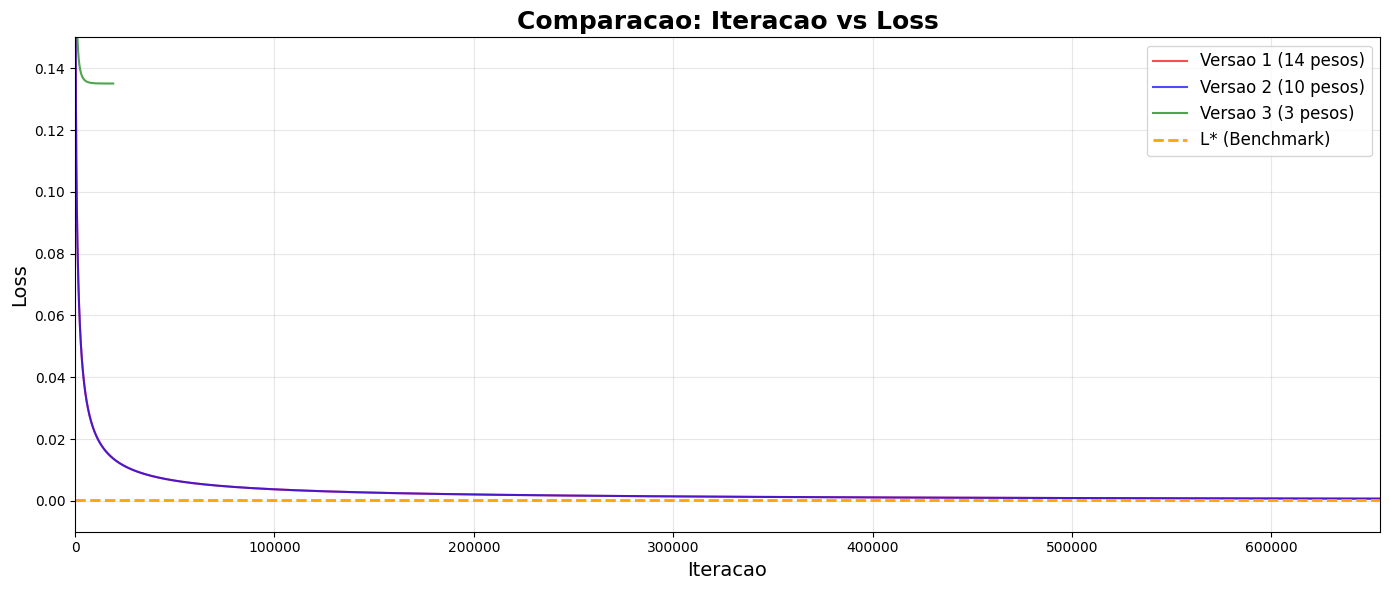

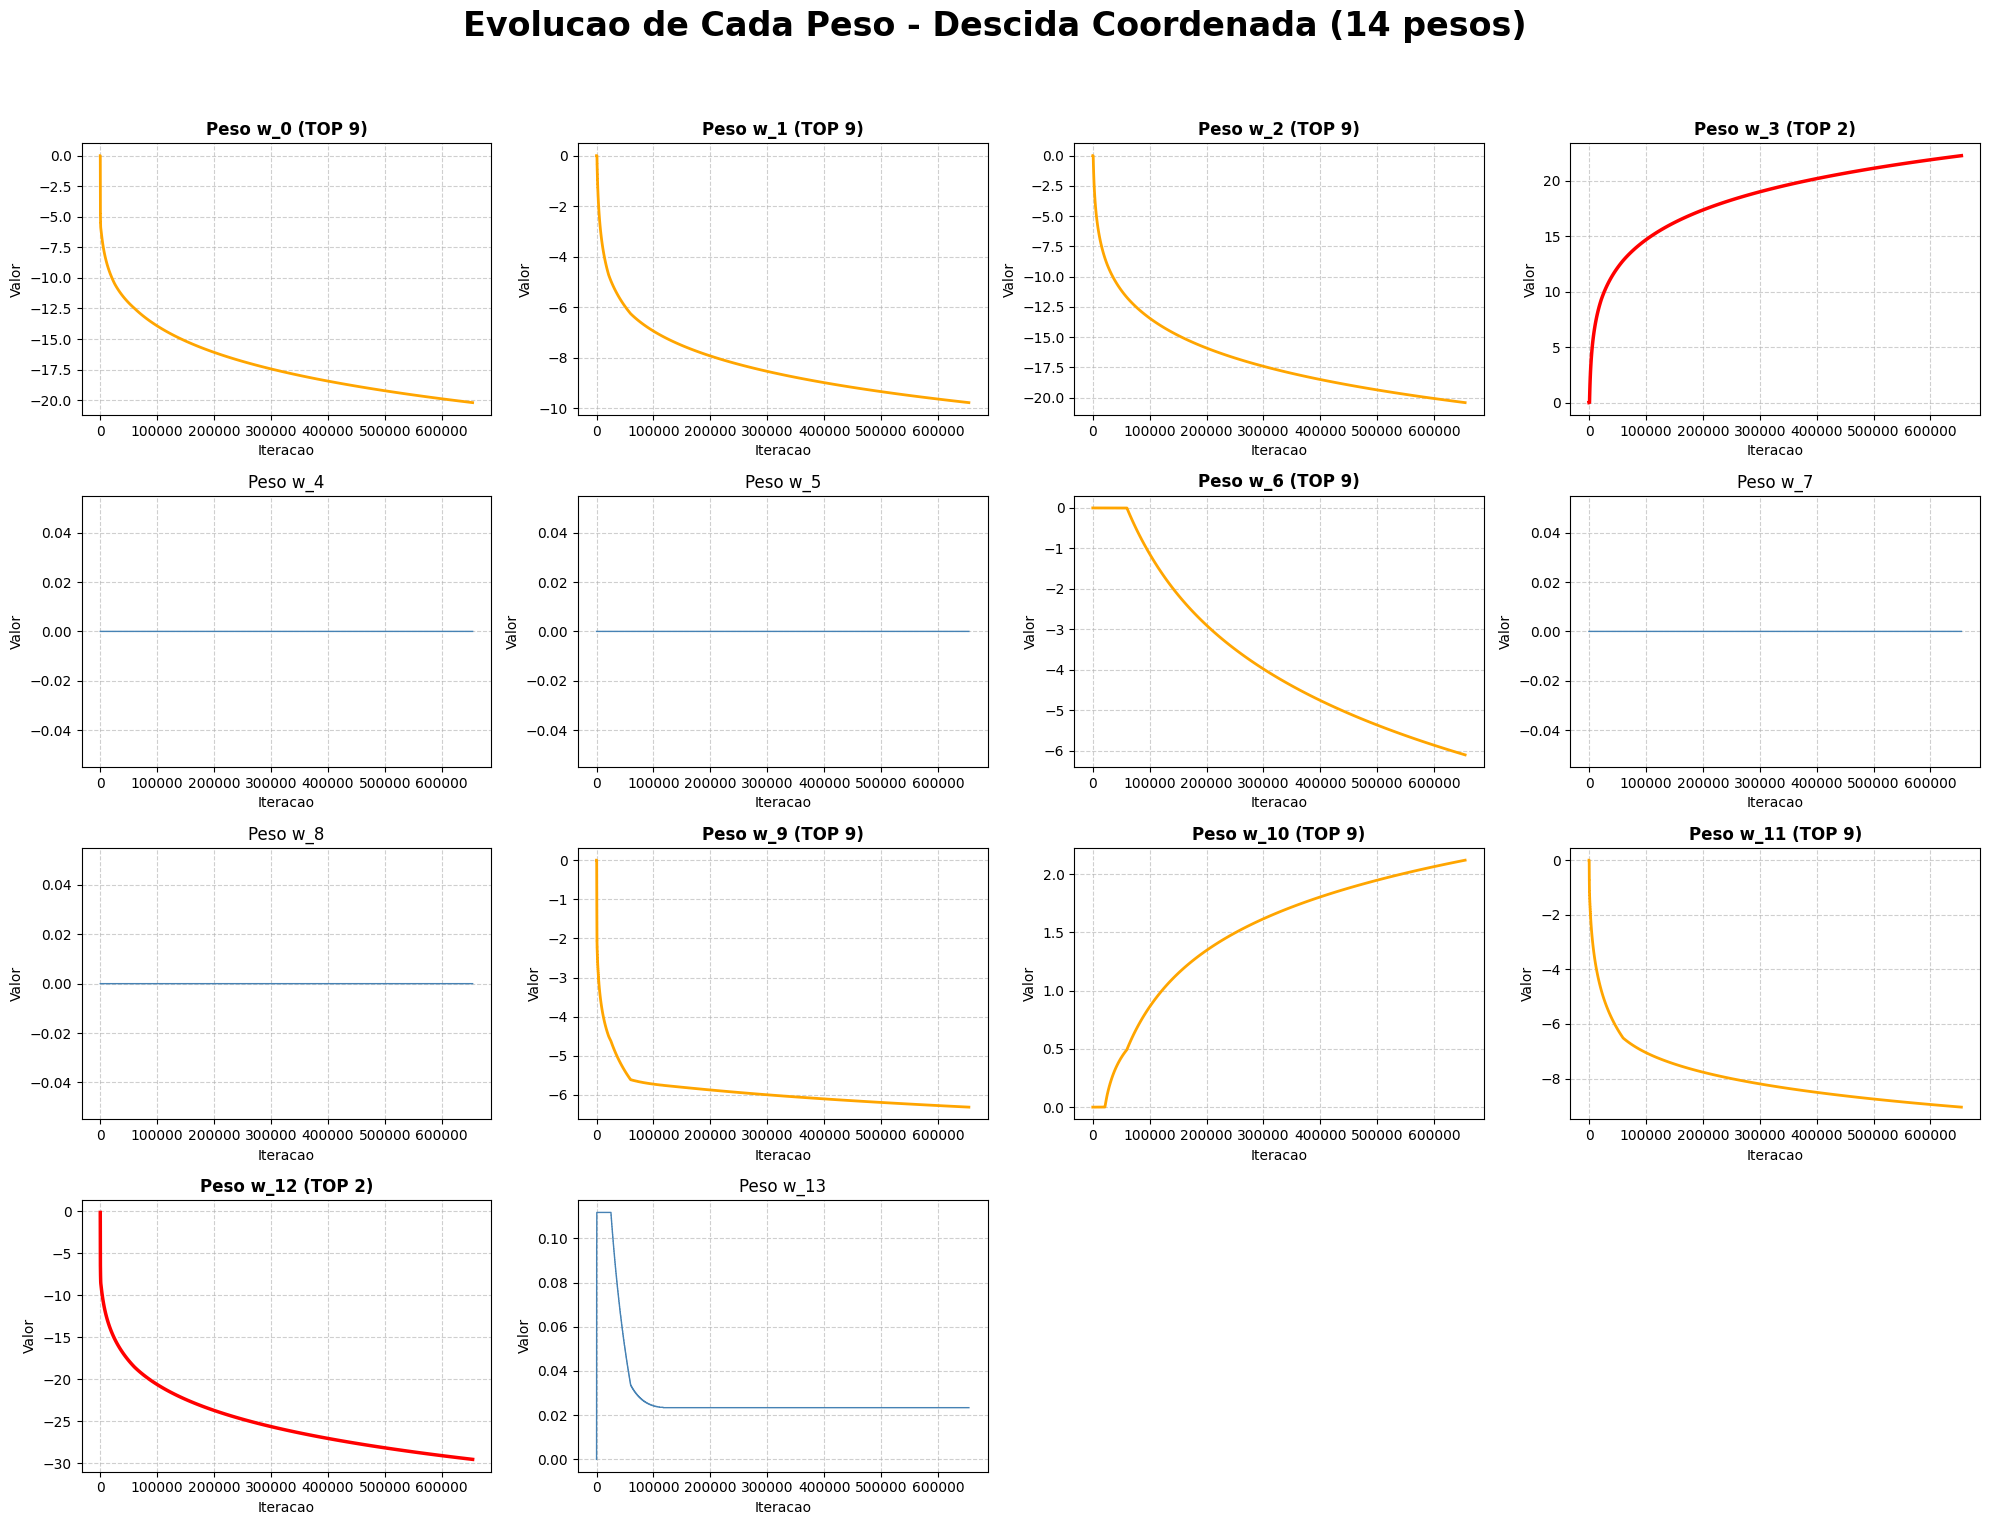

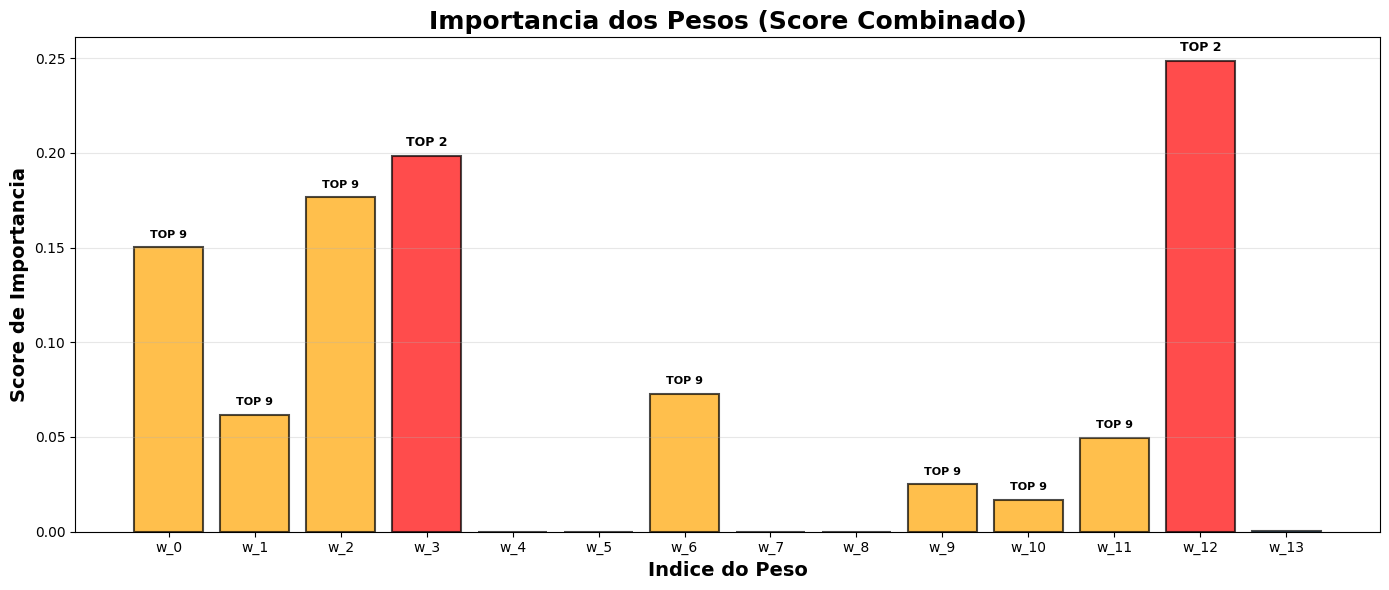


Calculando espaco de solucoes para versao com 2 pesos


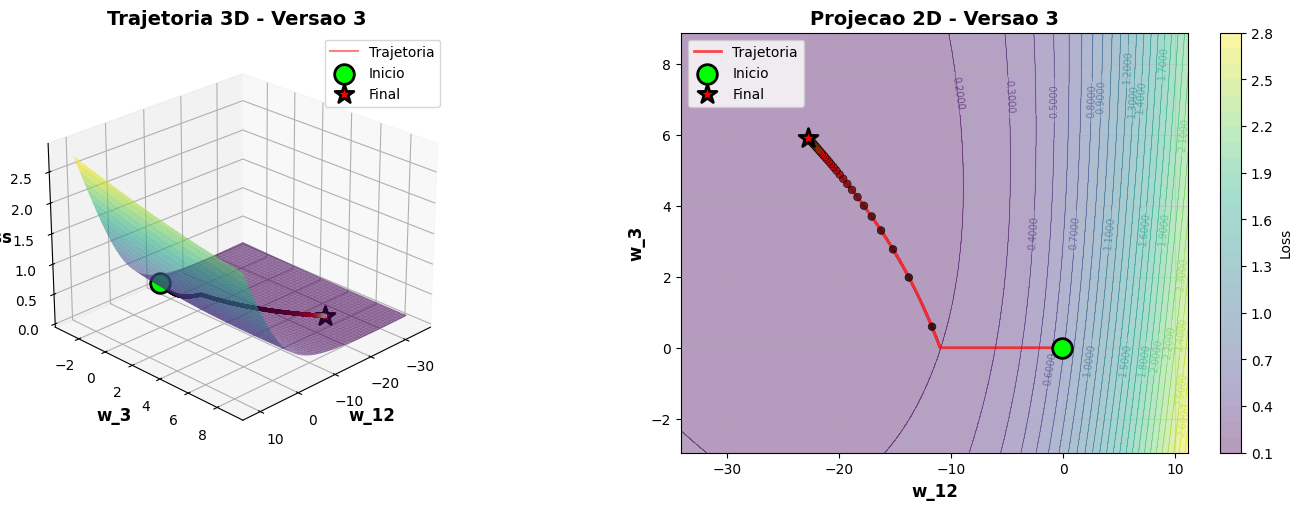

In [207]:
# Comparacao de Loss
plt.figure(figsize=(14, 6))
plt.plot(loss_gradient, 'r-', label=f'Versao 1 (14 pesos)', alpha=0.7, linewidth=1.5)
plt.plot(results_n['loss_history'], 'b-', label=f'Versao 2 ({len(feature_indices_n)} pesos)', alpha=0.7, linewidth=1.5)
plt.plot(results_2['loss_history'], 'g-', label=f'Versao 3 ({len(feature_indices_2)} pesos)', alpha=0.7, linewidth=1.5)
plt.axhline(y=L_star, color='orange', linestyle='--', linewidth=2, label='L* (Benchmark)')
plt.title('Comparacao: Iteracao vs Loss', fontsize=18, fontweight='bold')
plt.xlabel('Iteracao', fontsize=14)
plt.ylabel('Loss', fontsize=14)
max_iter_plot = max(total_iterations_14, results_n['iterations'], results_2['iterations'])
plt.xlim(0, max_iter_plot)
plt.ylim(-0.01, 0.15)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Evolucao dos 14 pesos
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
fig.suptitle('Evolucao de Cada Peso - Descida Coordenada (14 pesos)', 
             fontsize=24, fontweight='bold')
axes_flat = axes.flatten()

for i in range(num_features):
    ax = axes_flat[i]
    if i in top_2_indices:
        color, linewidth, label_suffix = 'red', 2.5, ' (TOP 2)'
    elif i in top_n_indices:
        color, linewidth, label_suffix = 'orange', 2.0, f' (TOP {N_WEIGHTS})'
    else:
        color, linewidth, label_suffix = 'steelblue', 1.0, ''
    
    ax.plot(weights_history_gradient[:, i], color=color, linewidth=linewidth)
    ax.set_title(f'Peso w_{i}{label_suffix}', fontsize=12, 
                fontweight='bold' if label_suffix else 'normal')
    ax.set_xlabel('Iteracao', fontsize=10)
    ax.set_ylabel('Valor', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)

axes_flat[14].axis('off')
axes_flat[15].axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Grafico de barras: Importancia
plt.figure(figsize=(14, 6))
x_pos = np.arange(num_features)
colors = []
for i in range(num_features):
    if i in top_2_indices:
        colors.append('red')
    elif i in top_n_indices:
        colors.append('orange')
    else:
        colors.append('steelblue')

bars = plt.bar(x_pos, importance_score, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
plt.xlabel('Indice do Peso', fontsize=14, fontweight='bold')
plt.ylabel('Score de Importancia', fontsize=14, fontweight='bold')
plt.title('Importancia dos Pesos (Score Combinado)', fontsize=18, fontweight='bold')
plt.xticks(x_pos, [f'w_{i}' for i in range(num_features)])
plt.grid(axis='y', alpha=0.3)

for i, (idx, score) in enumerate(zip(x_pos, importance_score)):
    if idx in top_2_indices:
        plt.text(i, score + 0.005, 'TOP 2', ha='center', fontsize=9, fontweight='bold')
    elif idx in top_n_indices:
        plt.text(i, score + 0.005, f'TOP {N_WEIGHTS}', ha='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# Visualizacao 3D - Apenas para versao com 2 pesos
print("\nCalculando espaco de solucoes para versao com 2 pesos")

w0_min, w0_max = results_2['weights_history'][:, 0].min(), results_2['weights_history'][:, 0].max()
w1_min, w1_max = results_2['weights_history'][:, 1].min(), results_2['weights_history'][:, 1].max()

w0_margin = (w0_max - w0_min) * 0.5
w1_margin = (w1_max - w1_min) * 0.5

w0_range = np.linspace(w0_min - w0_margin, w0_max + w0_margin, 100)
w1_range = np.linspace(w1_min - w1_margin, w1_max + w1_margin, 100)
W0, W1 = np.meshgrid(w0_range, w1_range)

Z = np.zeros_like(W0)

if len(feature_indices_2) == 3:
    bias_value = results_2['weights'][2, 0]
    for i in range(W0.shape[0]):
        for j in range(W0.shape[1]):
            w_temp = np.array([[W0[i, j]], [W1[i, j]], [bias_value]])
            Z[i, j] = compute_loss_for_weights(w_temp, X_2_weights, y)
else:
    for i in range(W0.shape[0]):
        for j in range(W0.shape[1]):
            w_temp = np.array([[W0[i, j]], [W1[i, j]]])
            Z[i, j] = compute_loss_for_weights(w_temp, X_2_weights, y)

fig = plt.figure(figsize=(18, 12))

# Vista 3D
ax1 = fig.add_subplot(221, projection='3d')
surface = ax1.plot_surface(W0, W1, Z, cmap='viridis', alpha=0.6, edgecolor='none', linewidth=0, antialiased=True)
iterations = np.arange(len(results_2['weights_history']))
scatter = ax1.scatter(results_2['weights_history'][:, 0], 
                      results_2['weights_history'][:, 1], 
                      results_2['loss_history'],
                      c=iterations, 
                      cmap='hot', 
                      s=3,
                      alpha=0.8)
ax1.plot(results_2['weights_history'][:, 0], 
         results_2['weights_history'][:, 1], 
         results_2['loss_history'], 
         'r-', 
         alpha=0.5, 
         linewidth=1.5,
         label='Trajetoria')
ax1.scatter([results_2['weights_history'][0, 0]], 
            [results_2['weights_history'][0, 1]], 
            [results_2['loss_history'][0]], 
            c='lime', 
            s=200, 
            marker='o', 
            label='Inicio',
            edgecolors='black',
            linewidths=2)
ax1.scatter([results_2['weights_history'][-1, 0]], 
            [results_2['weights_history'][-1, 1]], 
            [results_2['loss_history'][-1]], 
            c='red', 
            s=200, 
            marker='*', 
            label='Final',
            edgecolors='black',
            linewidths=2)
ax1.set_xlabel(f'w_{top_2_indices[0]}', fontsize=12, fontweight='bold')
ax1.set_ylabel(f'w_{top_2_indices[1]}', fontsize=12, fontweight='bold')
ax1.set_zlabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Trajetoria 3D - Versao 3', fontsize=14, fontweight='bold')
ax1.legend()
ax1.view_init(elev=25, azim=45)

# Projecao 2D
ax2 = fig.add_subplot(222)
levels = 30
contour = ax2.contour(W0, W1, Z, levels=levels, cmap='viridis', alpha=0.6, linewidths=0.5)
ax2.clabel(contour, inline=True, fontsize=7, fmt='%.4f')
contourf = ax2.contourf(W0, W1, Z, levels=levels, cmap='viridis', alpha=0.4)

trajectory = ax2.plot(results_2['weights_history'][:, 0], 
                      results_2['weights_history'][:, 1], 
                      'r-', 
                      alpha=0.7, 
                      linewidth=2,
                      label='Trajetoria')
step = max(1, len(results_2['weights_history']) // 50)
scatter2 = ax2.scatter(results_2['weights_history'][::step, 0], 
                       results_2['weights_history'][::step, 1], 
                       c=iterations[::step], 
                       cmap='hot', 
                       s=30, 
                       alpha=0.8,
                       edgecolors='black',
                       linewidths=0.5,
                       zorder=5)
ax2.scatter([results_2['weights_history'][0, 0]], 
            [results_2['weights_history'][0, 1]], 
            c='lime', 
            s=200, 
            marker='o', 
            label='Inicio', 
            edgecolors='black', 
            linewidths=2,
            zorder=10)
ax2.scatter([results_2['weights_history'][-1, 0]], 
            [results_2['weights_history'][-1, 1]], 
            c='red', 
            s=200, 
            marker='*', 
            label='Final', 
            edgecolors='black', 
            linewidths=2,
            zorder=10)
ax2.set_xlabel(f'w_{top_2_indices[0]}', fontsize=12, fontweight='bold')
ax2.set_ylabel(f'w_{top_2_indices[1]}', fontsize=12, fontweight='bold')
ax2.set_title('Projecao 2D - Versao 3', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)
plt.colorbar(contourf, ax=ax2, label='Loss')

In [208]:
print(f"\nConfiguracoes: N_WEIGHTS = {N_WEIGHTS}")
print(f"\nPesos selecionados:")
print(f"  - TOP {N_WEIGHTS}: {list(top_n_indices)}")
print(f"  - TOP 2: {list(top_2_indices)}")
print(f"\nConclusao:")
print(f"  A versao com {len(feature_indices_n) -1} pesos oferece:")
print(f"    - {speedup_n:.2f}% speedup")
print(f"    - {deg_n:.2f}% de degradacao na loss")
print(f"  A versao com {len(feature_indices_2) -1} pesos oferece:")
print(f"    - {speedup_2:.2f}% speedup")
print(f"    - {deg_2:.2f}% de degradacao na loss")


Configuracoes: N_WEIGHTS = 9

Pesos selecionados:
  - TOP 9: [np.int64(12), np.int64(3), np.int64(2), np.int64(0), np.int64(6), np.int64(1), np.int64(11), np.int64(9), np.int64(10)]
  - TOP 2: [np.int64(12), np.int64(3)]

Conclusao:
  A versao com 9 pesos oferece:
    - 25.11% speedup
    - 0.00% de degradacao na loss
  A versao com 2 pesos oferece:
    - 97.89% speedup
    - 19138.31% de degradacao na loss
